In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

| | |
|----------|-------------|
| Author(s)   | Lei Pan |
| Last updated | 11/27/2023 |

# Codey E2E Use Cases in Software Development Life Cycle

Codey models are text-to-code models from Google AI, trained on a massive code related dataset. You can generate code related responses for different scenarios such as writing functions, unit tests, debugging, explaining code etc. Here is [the overview](https://cloud.google.com/vertex-ai/docs/generative-ai/code/code-models-overview) of all the Codey APIs.

In this notebook, we will show you how to use Codey APIs to solve various tasks in software development life cycle such as code generation, unit test generation, code explanation, comment generation, code refactoring, debugging, migration as well as codebase, doc and JIRA search.

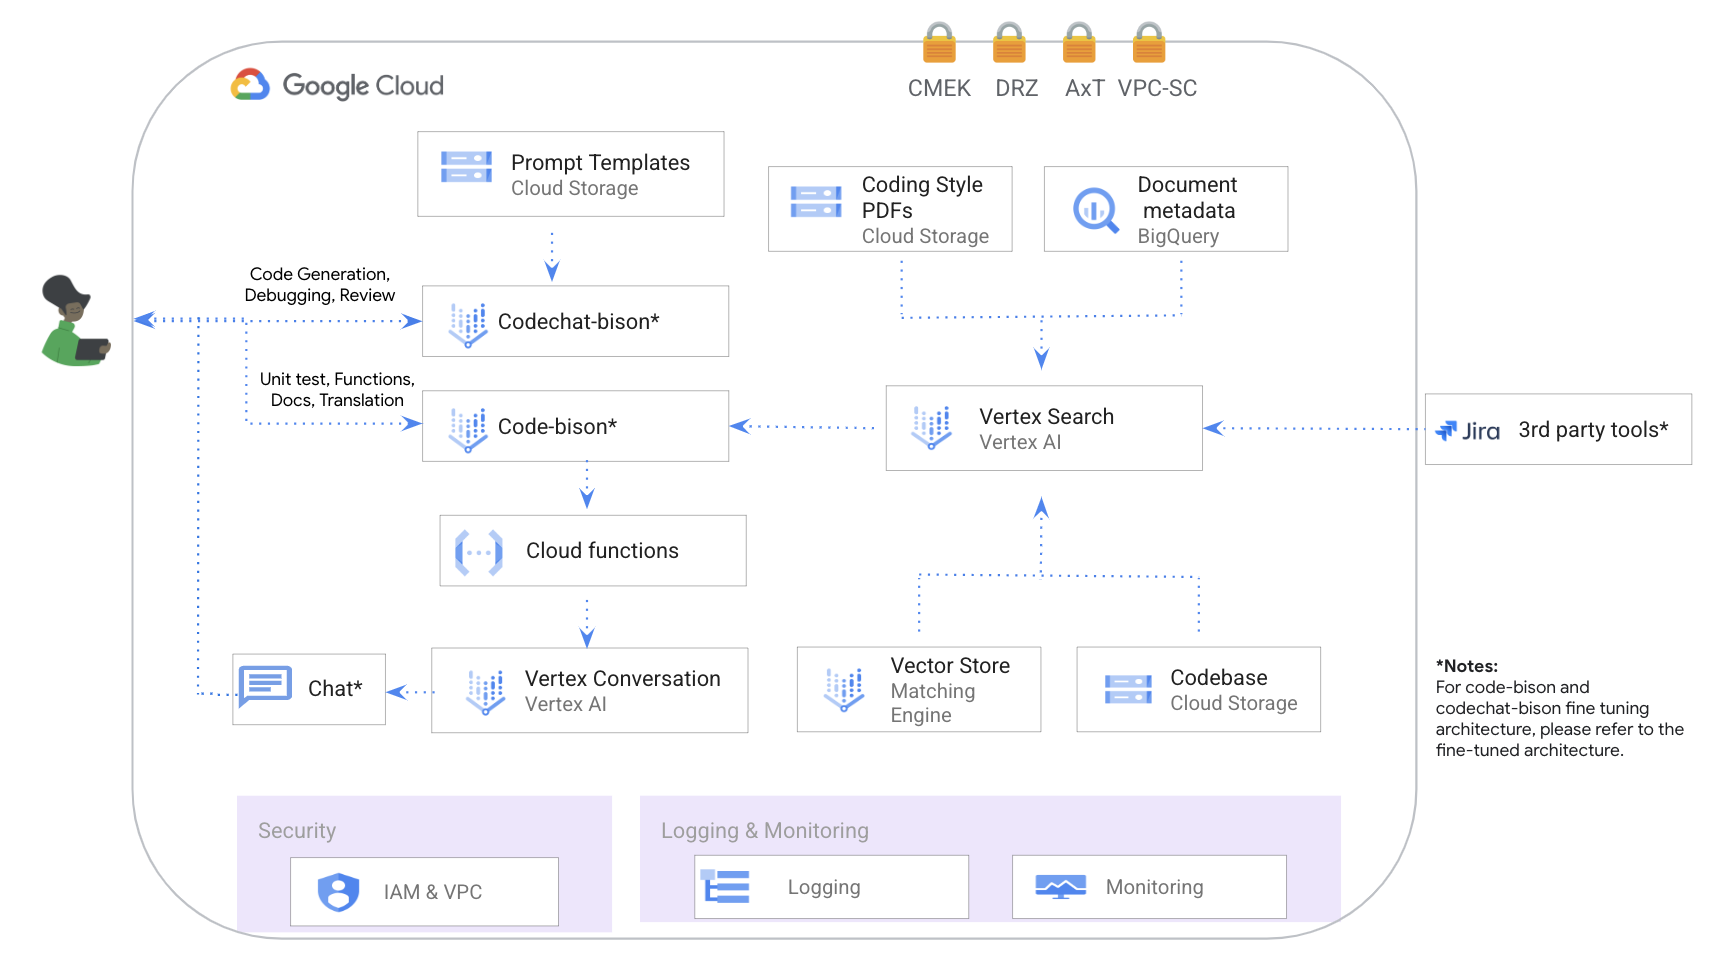

## Prep Work



### Install Vertex AI SDK, other packages and their dependencies

Install the following packages required to execute this notebook.

*To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    ! pip install google-cloud-aiplatform
    ! pip install google-cloud-discoveryengine
    ! pip install jsonlines
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

In [ ]:
import sys
import json
import os
import vertexai
import pandas as pd
from typing import Dict, List, Optional, Tuple
from google.cloud import discoveryengine
from google.protobuf.json_format import MessageToDict

### Initialize Vertex AI

Please set VERTEX_API_PROJECT and VERTEX_API_LOCATION below with your project id and location for Vertex AI. This should be the project in which you enabled Vertex AI

In [ ]:
import vertexai
from vertexai.preview.language_models import CodeGenerationModel
from vertexai.preview.language_models import CodeChatModel


VERTEX_API_PROJECT = '<project id>'
VERTEX_API_LOCATION = '<location>'

vertexai.init(project=VERTEX_API_PROJECT, location=VERTEX_API_LOCATION)

### Initialize Code Model

- You can specify the version of the Codey models you want to use. Here is [the list](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/model-versioning)  of all the available models


- You can pass 3 parameters here: prompt, max size of token, and temperature.

In [ ]:
code_generation_model = CodeGenerationModel.from_pretrained("code-bison@001")

def send_prompt(prefix, max_token=1024, model = code_generation_model):
    parameters = {
    "temperature": 0.2,
    "max_output_tokens": max_token
    }

    response = model.predict(
    prefix=prefix, **parameters
    )

    return response.text

## Code Generation
- Examples below demonstrate how to use Codey API to do code generation, unit test, refactor, explanation, comment generation, and code generation with fine-tuned model

### Example 1: Generate Code Using Codey Model

In [ ]:
prompt = """You are great at designing Object Oriented Programming solutions.
Design a parking lot using object-oriented principles in Java.
Here are the requirements:
[
1) The parking lot has multiple levels. Each level has multiple rows of spots.
2) The parking lot can park motorcycles, cars, and buses.
3) The parking lot has motorcycle spots, compact spots, and large spots.
4) A motorcycle can park in any spot.
5) A car can park in either a single compact spot or a single large spot.
6) A bus can park in five large spots that are consecutive and within the same row. It cannot park in small spots. In the below implementation, we have created an abstract class Vehicle, from which Car, Bus, and Motorcycle inherit. To handle the different parking spot sizes, we have just one class ParkingSpot which has a member variable indicating the size.
]"""
print(send_prompt (prompt))

```java
// Vehicle.java
// Abstract class Vehicle

abstract class Vehicle {
    private String licensePlate;
    private int spotsNeeded;
    private VehicleSize size;

    public Vehicle(String licensePlate, int spotsNeeded, VehicleSize size) {
        this.licensePlate = licensePlate;
        this.spotsNeeded = spotsNeeded;
        this.size = size;
    }

    public String getLicensePlate() {
        return licensePlate;
    }

    public int getSpotsNeeded() {
        return spotsNeeded;
    }

    public VehicleSize getSize() {
        return size;
    }
}

// Car.java
// Concrete class Car

class Car extends Vehicle {
    public Car(String licensePlate) {
        super(licensePlate, 1, VehicleSize.COMPACT);
    }
}

// Bus.java
// Concrete class Bus

class Bus extends Vehicle {
    public Bus(String licensePlate) {
        super(licensePlate, 5, VehicleSize.LARGE);
    }
}

// Motorcycle.java
// Concrete class Motorcycle

class Motorcycle extends Vehicle {
    public Motorcycle(S

In [ ]:
prompt = """
You are an expert in google cloud platform. Generate gcloud CLI to create a GKE cluster with cluster name [hello-cluster]
"""
print(send_prompt (prompt))

```
gcloud container clusters create hello-cluster \
  --num-nodes 3 \
  --machine-type n1-standard-1 \
  --enable-autoscaling \
  --min-nodes 1 \
  --max-nodes 10 \
  --enable-autorepair \
  --enable-autoprovisioning \
  --location us-central1-a

# Reference: https://cloud.google.com/kubernetes-engine/docs/concepts/autopilot-clusters
```


### Example 2: Use Fine-Tuned Model to Generate Vertext AI Search Code

If you haven't fine-tuned the model yet, you can follow this notebook - [2_codey_code_fine_tune_example.ipynb](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/tree/main/genai-on-vertex-ai/developer_productivity_with_genai/2_codey_code_fine_tune_example.ipynb) to fine tune the model

In [ ]:
list_models = CodeGenerationModel.from_pretrained("code-bison@001").list_tuned_model_names()
TUNED_MODEL_NAME = list_models[0]
tuned_model = CodeGenerationModel.get_tuned_model(TUNED_MODEL_NAME)
vertexai_search_code = send_prompt(prefix=prompt,model= tuned_model)
vertexai_search_code = vertexai_search_code.removeprefix(' ```python').removesuffix('```')
print(vertexai_search_code)

```python
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = client.search(request)

    return response


### Example 3 : Generate Unit Test

In [ ]:
unit_test_prompt = f"""
Generate unit test to cover this block of code {vertexai_search_code}
"""
print(send_prompt (prefix=unit_test_prompt))

```python
import unittest

from google.cloud import discoveryengine
from google.protobuf import json_format


class TestSearchSample(unittest.TestCase):

    def test_search_sample(self):
        project_id = "my-project"
        location = "us-central1"
        search_engine_id = "my-search-engine"
        serving_config_id = "my-serving-config"
        search_query = "hello world"

        results = search_sample(
            project_id=project_id,
            location=location,
            search_engine_id=search_engine_id,
            serving_config_id=serving_config_id,
            search_query=search_query,
        )

        self.assertIsNotNone(results)
        self.assertIsInstance(results, list)
        self.assertGreater(len(results), 0)

        for result in results:
            self.assertIsNotNone(result)
            self.assertIsInstance(result, discoveryengine.SearchResponse.SearchResult)
            self.assertIsNotNone(result.document)
            self.assertIsInstan

### Example 4 : Explain the Code

In [ ]:
explain_prompt = f"""
Explain this block of code {vertexai_search_code} line by line
"""
print(send_prompt (prefix=explain_prompt))

The function `search_sample` takes five arguments:

  * `project_id`: The ID of the project that the search engine belongs to.
  * `location`: The location of the search engine.
  * `search_engine_id`: The ID of the search engine.
  * `serving_config_id`: The ID of the serving configuration to use.
  * `search_query`: The search query to use.

The function first creates a client for the Discovery Engine API. It then uses
the client to create a `serving_config` object, which specifies the project,
location, search engine ID, and serving configuration ID.

The function then creates a `SearchRequest` object, which specifies the
`serving_config` and the search query. It then sends the request to the
Discovery Engine API and gets a `SearchResponse` object in return.

The function then iterates over the `results` field of the `SearchResponse`
object and converts each result to a dictionary. It then returns the list of
dictionaries.

Here is a more detailed explanation of each line of code:



### Example 5 : Refactor the Code

In [ ]:
refactor_prompt = f"""
Refactor this block of code {vertexai_search_code} by using descriptive and meaningful names and comments
"""
print(send_prompt(prefix=refactor_prompt))

```python
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    """
    Searches for results in the given search engine.

    Args:
        project_id: The ID of the project that owns the search engine.
        location: The location of the search engine.
        search_engine_id: The ID of the search engine.
        serving_config_id: The ID of the serving config to use.
        search_query: The query to search for.

    Returns:
        A list of search results.
    """

    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = clie

### Example 6 : Generate Comments

In [ ]:
comment_prompt = f"""
Generate line-by-line comments for this block of code {vertexai_search_code}
"""
print(send_prompt (prefix=comment_prompt))

This function performs a search using the Discovery Engine API.

The function takes four arguments:

* `project_id`: The ID of the project that the search engine belongs to.
* `location`: The location of the search engine.
* `search_engine_id`: The ID of the search engine.
* `serving_config_id`: The ID of the serving configuration to use for the search.

The function returns a list of `SearchResult` objects, which contain information about the documents that were found in the search.

Here is a more detailed explanation of each line of code:

* `client = discoveryengine.SearchServiceClient()`: This creates a client object for the Discovery Engine API.
* `serving_config = client.serving_config_path(project=project_id, location=location, data_store=search_engine_id, serving_config=serving_config_id)`: This constructs the path to the serving configuration to use for the search.
* `request = discoveryengine.SearchRequest(serving_config=serving_config, query=search_query)`: This creates a `

## Code Debugging

### Step 1: Set up Code Chat Model

Code Chat model is more suitable for debugging and migration tasks. Let's set up call code chat model here. It's similar to the code generation model above. One difference is that you need to call start_chat. You can set up the project id and location below if you want to use code chat model from a different GCP project.

In [ ]:
VERTEX_API_PROJECT = '<project>'
VERTEX_API_LOCATION = '<location>'

vertexai.init(project=VERTEX_API_PROJECT, location=VERTEX_API_LOCATION)
code_chat_model = CodeChatModel.from_pretrained("codechat-bison")

chat = code_chat_model.start_chat()

def send_message(message, max_token=1024):
    parameters = {
    "temperature": 0,
    "max_output_tokens": max_token
    }
    response = chat.send_message(message, **parameters)
    return response.text

### Step 2: Load Prompt Templates from GCS

We used a prompt template in this example. For prompt templates that work, it would be useful to store them in a central location so that team can reuse it.

How to set up the prompt template:
- Step 1: Create a GCS bucket by following [this doc](https://cloud.google.com/storage/docs/creating-buckets)
- Step 2: For this example, you can upload [this csv](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/developer_productivity_with_genai/prompt_templates/Debugging-Prompt-Template.csv) to the bucket you created above.
- Step 3: Replace prompt template GCS URL below with the URL to your GCS bucket


In [ ]:
prompt_templates = pd.read_csv('gs://<your GCS bucket path>/Debugging-Prompt-Template.csv', sep = ',')

### Step 3: Fix Code Based on Error Message

In [ ]:
error_message = """
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-14-8c52ce2d8248> in <cell line: 16>()
     15
     16 for contest in move_data.Contest.unique():
---> 17     data_subset = move_data[move_data.Move_Contest == contest]
     18     plt.scatter(data_subset.Power,
     19                 data_subset.Accuracy, label = contest)

/usr/local/lib/python3.10/dist-packages/pandas/core/generic.py in __getattr__(self, name)
   5900         ):
   5901             return self[name]
-> 5902         return object.__getattribute__(self, name)
   5903
   5904     def __setattr__(self, name: str, value) -> None:

AttributeError: 'DataFrame' object has no attribute 'Move_Contest'
"""

context = """
plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://<your GCS bucket path>/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_eval})
move_data = pd.read_csv('gs://<your GCS bucket path>/move-data.csv', index_col = 0)
for var in ['Power', 'Accuracy']:
    move_data[var].replace('None', np.nan, inplace=True)
    move_data[var] = move_data[var].astype(float)

for contest in move_data.Contest.unique():
    data_subset = move_data[move_data.Move_Contest == contest]
    plt.scatter(data_subset.Power,
                data_subset.Accuracy, label = contest)
    plt.xlabel('Power')
    plt.ylabel('Accuracy')
plt.legend(loc = 'lower left', bbox_to_anchor = (1, 0))
plt.show()
"""

In [ ]:
debug_context_prompt = prompt_templates[prompt_templates['Type']=='Debugging with Context']['Prompt Template'][1]
print(debug_context_prompt)

Here is the original code: {context}. Please fix the original code based on the error message below: {error_message} and and explain what you fixed


In [ ]:
response = send_message(debug_context_prompt.format(context=context,error_message=error_message))

#response = send_message(prompt1)
def break_response_to_lines(response):
  response_lines = response.split("\n")
  for line in response_lines:
      print(line)
break_response_to_lines(response)

 The original code has the following error:

```
AttributeError: 'DataFrame' object has no attribute 'Move_Contest'
```

This error is because the `move_data` DataFrame does not have a column named `Move_Contest`. To fix this error, you can add the column to the DataFrame using the following code:

```python
move_data['Move_Contest'] = move_data['Contest'].apply(lambda x: x.split('_')[0])
```

This code uses the `apply()` method to add a new column to the DataFrame. The `lambda` function extracts the first part of the `Contest` column value, which is the contest name.

Once you have added the `Move_Contest` column to the DataFrame, you can then use it to filter the data and create the scatter plot. The following code shows the updated code:

```python
plt.style.use('seaborn-ticks')
pokemon_data = pd.read_csv('gs://demo_test_public_bucket/uj13/pokemon-data.csv',
                           sep = ';', converters={'Types':ast.literal_eval, 'Abilities':ast.literal_eval, 'Moves':ast.literal_

## Code Migration

### Step 1: Load Prompt Templates from GCS

We used a prompt template in this example. For prompt templates that work, it would be useful to store them in a central location so that team can reuse it.

How to set up the prompt template:
- Step 1: Create a GCS bucket by following [this doc](https://cloud.google.com/storage/docs/creating-buckets)
- Step 2: For this example, you can upload [this csv](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/blob/main/genai-on-vertex-ai/developer_productivity_with_genai/prompt_templates/Migration-Prompt-Template.csv) to the bucket you created above.
- Step 3: Replace prompt template GCS URL below with the URL to your GCS bucket

In [ ]:
prompt_templates = pd.read_csv('gs://<your GCS bucket path>/Migration-Prompt-Template.csv', sep = ',')

### Step 2: COBOL Migration with Step by Step Instructions

In [ ]:
cobol_migration_prompt = prompt_templates[prompt_templates['Type']=='Basic Migration']['Prompt Template'][0]
print(cobol_migration_prompt)

You are great at migrating code from COBOL to Java. Here is the COBOL code: {cobol_file}

Please covert it to Java by following the prompt instructions below to do that:

Step 1: Generate Java classes from COBOL data structures. Each COBOL data structure should correspond to a Java class. Ensure proper data type mapping and encapsulation.

Step 2: Translate COBOL file input/output operations to Java file handling operations

Step 3: Migrate COBOL business logic to Java. Convert COBOL procedures, paragraphs, and sections to Java methods. Ensure equivalent functionality

Step 4: Convert COBOL conditional statements (IF, ELSE, etc.) to Java if-else statements and loops (PERFORM, etc.) to Java loops (for, while, etc.). Ensure logical equivalence

Step 5: Replace COBOL-specific functions and operations with Java equivalents. This includes arithmetic operations, string manipulations, and date/time functions.

Step 6: Generate Java constants from COBOL copybooks. Each COBOL constant should be

In [ ]:
cobol_file = """
IDENTIFICATION DIVISION.
       PROGRAM-ID.  CPSEQFR.
       ENVIRONMENT DIVISION.
       INPUT-OUTPUT SECTION.
       FILE-CONTROL.
           SELECT INFILE ASSIGN  TO 'INFILE1'
                  FILE STATUS IS INPUT-FILE-STATUS.
           SELECT OUTFILE ASSIGN TO 'OUTFILE1'
               FILE STATUS IS OUTPUT-FILE-STATUS.
       DATA DIVISION.
       FILE SECTION.
       FD  INFILE
           LABEL RECORDS ARE STANDARD
           DATA RECORD IS INPUT-RECORD
           RECORD CONTAINS 40 CHARACTERS
           RECORDING MODE IS F
           BLOCK CONTAINS 0 RECORDS.
       01  INPUT-RECORD.
           05 INPUT-FIRST-10      PIC X(10).
           05 INPUT-LAST-30       PIC X(30).

       FD  OUTFILE
           LABEL RECORDS ARE STANDARD
           DATA RECORD IS OUTPUT-RECORD
           RECORD CONTAINS 40 CHARACTERS
           RECORDING MODE IS F
           BLOCK CONTAINS 0 RECORDS.
       01  OUTPUT-RECORD.
           05 OUTPUT-FIRST-30     PIC X(30).
           05 OUTPUT-LAST-10      PIC X(10).

       WORKING-STORAGE SECTION.
       01  WorkAreas.
           05  INPUT-FILE-STATUS  PIC X(02).
               88  GOOD-READ      VALUE '00'.
               88  END-OF-INPUT   VALUE '10'.
           05  OUTPUT-FILE-STATUS PIC X(02).
               88  GOOD-WRITE     VALUE '00'.
           05  RECORD-COUNT       PIC S9(5) COMP-3.

       PROCEDURE DIVISION.
           OPEN INPUT INFILE
           IF NOT GOOD-READ
               DISPLAY 'STATUS ON INFILE OPEN: ' INPUT-FILE-STATUS
               GO TO END-OF-PROGRAM
           END-IF
           OPEN OUTPUT OUTFILE
           IF NOT GOOD-WRITE
               DISPLAY 'STATUS ON OUTFILE OPEN: ' OUTPUT-FILE-STATUS
           END-IF
           PERFORM UNTIL END-OF-INPUT
               READ INFILE
               IF GOOD-READ
                   MOVE INPUT-FIRST-10 TO OUTPUT-LAST-10
                   MOVE INPUT-LAST-30 TO OUTPUT-FIRST-30
                   WRITE OUTPUT-RECORD
                   IF GOOD-WRITE
                        ADD 1 TO RECORD-COUNT
                   ELSE
                       DISPLAY 'STATUS ON OUTFILE WRITE: '
                               OUTPUT-FILE-STATUS
                       GO TO END-OF-PROGRAM
                   END-IF
               END-IF
           END-PERFORM
           .
       END-OF-PROGRAM.
           DISPLAY 'NUMBER OF RECORDS PROCESSED: ' RECORD-COUNT
           CLOSE INFILE
           CLOSE OUTFILE
           GOBACK.

"""

In [ ]:
response = send_message(cobol_migration_prompt.format(cobol_file=cobol_file))

In [ ]:
response_lines = response.split("\n")
for line in response_lines:
    print(line)

 ```java
import java.io.*;

public class CPSEQFR {

    public static void main(String[] args) {

        // Generate Java classes from COBOL data structures
        InputRecord inputRecord = new InputRecord();
        OutputRecord outputRecord = new OutputRecord();

        // Translate COBOL file input/output operations to Java file handling operations
        File infile = new File("INFILE1");
        File outfile = new File("OUTFILE1");

        try {
            // Open input file
            BufferedReader reader = new BufferedReader(new FileReader(infile));

            // Open output file
            BufferedWriter writer = new BufferedWriter(new FileWriter(outfile));

            // Migrate COBOL business logic to Java
            String line;
            while ((line = reader.readLine()) != null) {
                // Convert COBOL conditional statements (IF, ELSE, etc.) to Java if-else statements
                if (line.length() == 40) {
                    // Convert COBOL 

## Codebase Search & Doc Search

### Step 1: Codebase Matching Engine & Langchain Setup

The cell below will download some helper functions needed for using [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) in this notebook. These helper functions were created to keep this notebook more tidy and concise, and you can also [view them directly on Github](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/language/use-cases/document-qa/utils).

In [ ]:
import os
import urllib.request

if not os.path.exists("utils"):
    os.makedirs("utils")

url_prefix = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/language/use-cases/document-qa/utils"
files = ["__init__.py", "matching_engine.py", "matching_engine_utils.py"]

for fname in files:
    urllib.request.urlretrieve(f"{url_prefix}/{fname}", filename=f"utils/{fname}")

import json
import textwrap

# Utils
import time
import uuid
from typing import List

import numpy as np
import vertexai

# Vertex AI
from google.cloud import aiplatform

print(f"Vertex AI SDK version: {aiplatform.__version__}")

# LangChain
import langchain

print(f"LangChain version: {langchain.__version__}")

from langchain.chains import RetrievalQA
from langchain.document_loaders import GCSDirectoryLoader
from langchain.embeddings import VertexAIEmbeddings
from langchain.llms import VertexAI
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pydantic import BaseModel

# Import custom Matching Engine packages
from utils.matching_engine import MatchingEngine
from utils.matching_engine_utils import MatchingEngineUtils

PROJECT_ID = "<project id>"
REGION = "<location>"

# Initialize Vertex AI SDK
vertexai.init(project=PROJECT_ID, location=REGION)

# Utility functions for Embeddings API with rate limiting
def rate_limit(max_per_minute):
    period = 60 / max_per_minute
    print("Waiting")
    while True:
        before = time.time()
        yield
        after = time.time()
        elapsed = after - before
        sleep_time = max(0, period - elapsed)
        if sleep_time > 0:
            print(".", end="")
            time.sleep(sleep_time)


class CustomVertexAIEmbeddings(VertexAIEmbeddings, BaseModel):
    requests_per_minute: int
    num_instances_per_batch: int

    # Overriding embed_documents method
    def embed_documents(self, texts: List[str]):
        limiter = rate_limit(self.requests_per_minute)
        results = []
        docs = list(texts)

        while docs:
            # Working in batches because the API accepts maximum 5
            # documents per request to get embeddings
            head, docs = (
                docs[: self.num_instances_per_batch],
                docs[self.num_instances_per_batch :],
            )
            chunk = self.client.get_embeddings(head)
            results.extend(chunk)
            next(limiter)

        return [r.values for r in results]

# Text model instance integrated with langChain
llm = VertexAI(
    model_name="code-bison",
    max_output_tokens=1024,
    temperature=0.2
)

### Step 2: Codebase Vector Store Setup

- Get Matching Engine Index id and Endpoint id
- If you haven't set up codebase in the vector store, please run this notebook to set it up: 5_codey_talk_to_codebase_example.ipynb. [github link](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/tree/main/genai-on-vertex-ai/developer_productivity_with_genai/5_codey_talk_to_codebase_example.ipynb)

In [ ]:

# Embeddings API integrated with langChain
EMBEDDING_QPM = 100
EMBEDDING_NUM_BATCH = 5
embeddings = CustomVertexAIEmbeddings(
    requests_per_minute=EMBEDDING_QPM,
    num_instances_per_batch=EMBEDDING_NUM_BATCH,
)
ME_REGION = "us-central1"
ME_INDEX_NAME = f"{PROJECT_ID}-me-index"
ME_EMBEDDING_DIR = f"{PROJECT_ID}-me-bucket"
ME_DIMENSIONS = 768  # when using Vertex PaLM Embedding
mengine = MatchingEngineUtils(PROJECT_ID, ME_REGION, ME_INDEX_NAME)
ME_INDEX_ID, ME_INDEX_ENDPOINT_ID = mengine.get_index_and_endpoint()
print(f"ME_INDEX_ID={ME_INDEX_ID}")
print(f"ME_INDEX_ENDPOINT_ID={ME_INDEX_ENDPOINT_ID}")

# initialize vector store
me = MatchingEngine.from_components(
    project_id=PROJECT_ID,
    region=ME_REGION,
    gcs_bucket_name=f"gs://{ME_EMBEDDING_DIR}".split("/")[2],
    embedding=embeddings,
    index_id=ME_INDEX_ID,
    endpoint_id=ME_INDEX_ENDPOINT_ID,
)

### Step 3: Codebase Search Retriever (Bank of Anthos)

In [ ]:
# Create chain to answer questions
NUMBER_OF_RESULTS = 3
SEARCH_DISTANCE_THRESHOLD = 0.6

# Expose index to the retriever
code_retriever = me.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": NUMBER_OF_RESULTS,
        "search_distance": SEARCH_DISTANCE_THRESHOLD,
    },
)

### Step 4: Doc Search Retriever (Coding Style Guides)

You need to ingest coding style pdfs to a Vertex AI search engine before you run the step below. This is how you build it.

- Public doc: [how to set up unstructured data store in vertex ai search](https://cloud.google.com/generative-ai-app-builder/docs/create-data-store-es#cloud-storage)
- For PDFs: download those [PDFs](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/tree/main/genai-on-vertex-ai/developer_productivity_with_genai/pdfs) and upload them to vertex AI search engine datastore.
- Once you set the datastore up, you will find the search engine id in the Data Stores UI. Use that id to set up SEARCH_ENGINE_ID below.

In [ ]:
from langchain.retrievers import GoogleCloudEnterpriseSearchRetriever as EnterpriseSearchRetriever

SEARCH_ENGINE_ID = "search engine id"

doc_retriever=EnterpriseSearchRetriever(
    project_id=PROJECT_ID,
    search_engine_id=SEARCH_ENGINE_ID,
    max_documents=3,
)

### Step 5: JIRA Retriever

You need to index JIRA website links in a Vertex AI search engine before you run the step below. This is how you build it.

- Public doc: [how to set up website indexes data store in vertex ai search](https://cloud.google.com/generative-ai-app-builder/docs/create-data-store-es#website)
- For JIRA website links: you can use this link - "issues.apache.org/jira/projects/FLINK/issues/*" and set it in the vertex AI search engine datastore.
- Once you set the datastore up, you will find the search engine id in the Data Stores UI. Use that id to set up SEARCH_ENGINE_ID below.

In the future, when JIRA connector for Vertex AI Search is GA, you can follow [this doc](https://cloud.google.com/generative-ai-app-builder/docs/create-data-store-es#jira) to do it in a different way.

In [ ]:
SEARCH_ENGINE_ID = "search engine id"

jira_retriever=EnterpriseSearchRetriever(
    project_id=PROJECT_ID,
    search_engine_id=SEARCH_ENGINE_ID,
    max_documents=3,
)

### Step 6: Dynamically Select from 3 Retrievers with RouterChain paradigm

You can dymanically talk to multiple retrievers by using MultiRetrievalQAChain. You can read more about it from [this langchain doc](https://js.langchain.com/docs/modules/chains/additional/multi_retrieval_qa_router)

In [ ]:
from langchain.chains.router import MultiRetrievalQAChain
retriever_infos = [
    {
        "name": "codebase search",
        "description": "Good for answering questions about the code in the codebase",
        "retriever": code_retriever
    },
    {
        "name": "coding style guide",
        "description": "Good for answering questions about coding styles such as python coding styles, java coding styles, c++ coding styles, etc",
        "retriever": doc_retriever
    },
    {
        "name": "jira issues search",
        "description": "Good for answering questions about jira issues",
        "retriever": jira_retriever
    }
]

In [ ]:
from langchain.chains import ConversationChain

DEFAULT_TEMPLATE = """The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
{history}
Human: {input}
AI:"""

prompt_default_template = DEFAULT_TEMPLATE.replace('input', 'query')

prompt_default = PromptTemplate(
    template=prompt_default_template, input_variables=['history', 'query']
)
default_chain=ConversationChain(llm=llm, prompt=prompt_default, input_key='query', output_key='result')

chain = MultiRetrievalQAChain.from_retrievers(llm, retriever_infos, default_chain=default_chain)

#### Sanity Check

In [ ]:
chain('hi')['result']

/root/.local/lib/python3.10/site-packages/langchain/chains/llm.py:280: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


' Hello. How may I assist you today?\n'

#### Talk to 3 Retrievers - Codebase, JIRA, and Coding Style PDFs

In [ ]:
chain("how does CI/CD pipeline that powers Bank of Anthos work?")['result']

/root/.local/lib/python3.10/site-packages/langchain/chains/llm.py:280: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Waiting


' The CI/CD pipeline for Bank of Anthos uses Cloud Build and Cloud Deploy, with the help of Terraform, Skaffold, and Kustomize. \n\nThe pipeline includes: \n* Terraform scripts for all Google Cloud resources\n* 3 GKE Autopilot clusters in a fleet\n* 1 Cloud Build trigger for GitHub PRs\n* 6 Cloud Build triggers for staging (1 per service)\n* 2 Cloud SQL databases (1 for staging, 1 for production)\n* 2-stage Cloud Deploy pipelines (staging and production)\n* Anthos Config Management set-up for staging and production\n* Anthos Service Mesh set-up for staging and production\n* Artifact Registry repository for container images\n* Cloud Storage bucket for Terraform state\n* Cloud Storage bucket for ledger monolith artifacts\n* IAM bindings and service accounts\n\nThe pipeline results in:\n* CI per service with Skaffold profile per environment\n* CD per service with Skaffold profile per environment\n\nThe development environment includes:\n* GKE Autopilot (one namespace per deployment)\n* AC

In [ ]:
chain("Tell me more about the best java style according to the java coding style guide.")['result']

/root/.local/lib/python3.10/site-packages/langchain/chains/llm.py:280: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


' The best Java style is the Google Java style. It emphasizes readability and maintainability. You can find more information about it here: https://google.github.io/styleguide/javaguide.html'

In [ ]:
chain("What are the top 2 flink issues in JIRA?")['result']

/root/.local/lib/python3.10/site-packages/langchain/chains/llm.py:280: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


" The top 2 Flink issues in JIRA are:\n1. [FLINK-26173] - Flink's checkpointing mechanism can lead to data loss in certain scenarios\n2. [FLINK-25934] - Flink's resource management can lead to performance degradation in certain scenarios"

### Step 7: Deploy to Dialogflow and Google Chat (Optional)

If you want to deploy the multichain retriever to a chatbot, this is how you can do it with GCP Conversational AI and Google Chat interface.

This step is optional. Implement it if you want to test out the chatbot integration.

**Step 1: Deploy Cloud Functions Code which Uses MultiRetrievalQAChain to Retrieve Information (Embedding Spaces + RAG + Codey) from 3 Different Retriever Embedding Spaces**
- Public doc: [How to deploy cloud function](https://cloud.google.com/functions/docs/deploy)
- Deploy below 3 sources to cloud functions as shown in the screenshot below
- Webhook cloud function code. Copy [the code here](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/tree/main/genai-on-vertex-ai/developer_productivity_with_genai/utilities/webhook_cloud_function.py) to cloud functions as main.py
- Requirements.text: below code is all you need.
>    
```
Flask==2.2.2
Werkzeug==2.3.7
google-cloud-aiplatform
google-cloud-discoveryengine
langchain==0.0.236
```

- You can download [matching_engine.py and mathcing_engine_utils.py here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/language/use-cases/document-qa/utils).

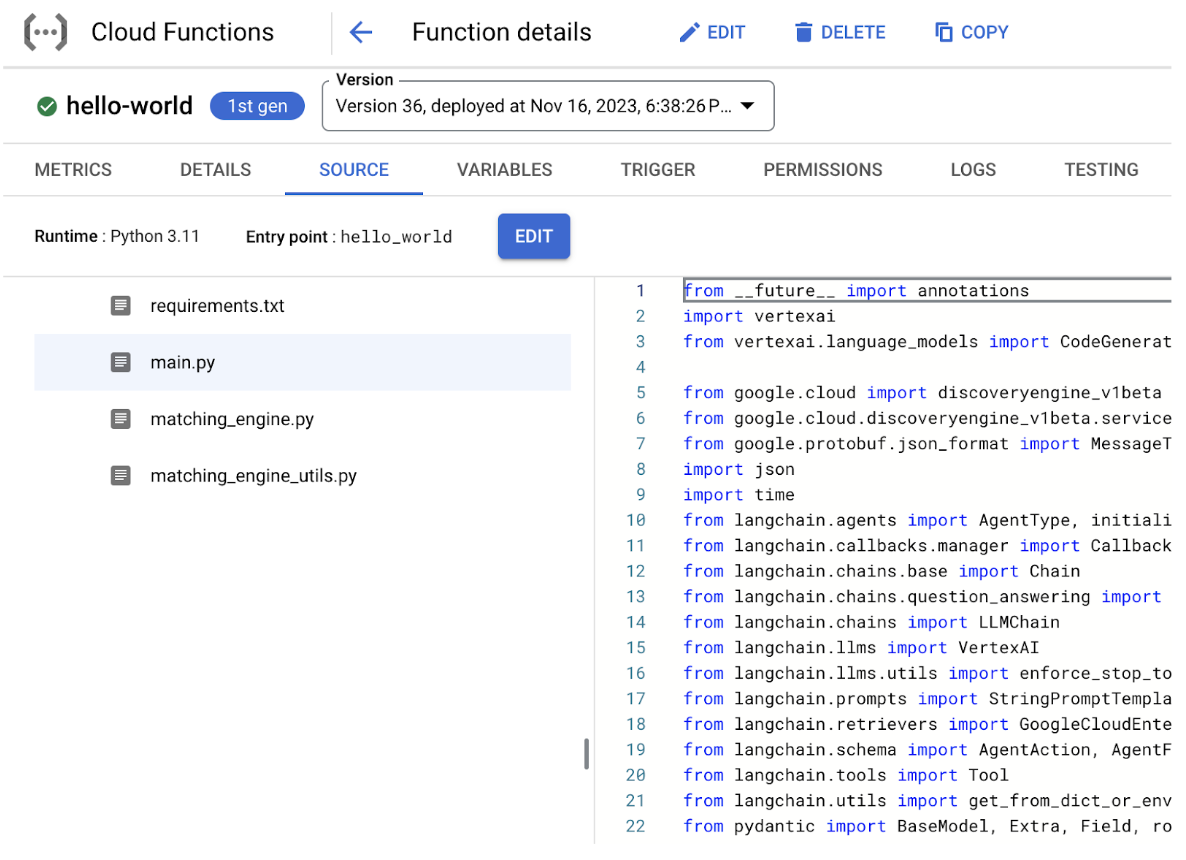

**Step 2: Call Cloud Function in Webhook in a Dialogflow Project**
- Public doc: [How to set up a dialogflow project](https://cloud.google.com/dialogflow/cx/docs/quick/setup)
- Public doc: [How to set up webhook with cloud function](https://cloud.google.com/dialogflow/cx/docs/concept/webhook)
- Once you set it up, go to default welcome intent, sys.no-match-default, sys.no-input-default and set the agent response to the response from webhook (cloud function that you deployed), please refer to the screenshot below.
- Public doc: [How to deploy dialogflow project to Google Chat](https://cloud.google.com/dialogflow/es/docs/integrations/google-chat)
- After you deploy the dialogflow project to Google chat, you should be able to search the chatbot in your Google chat



 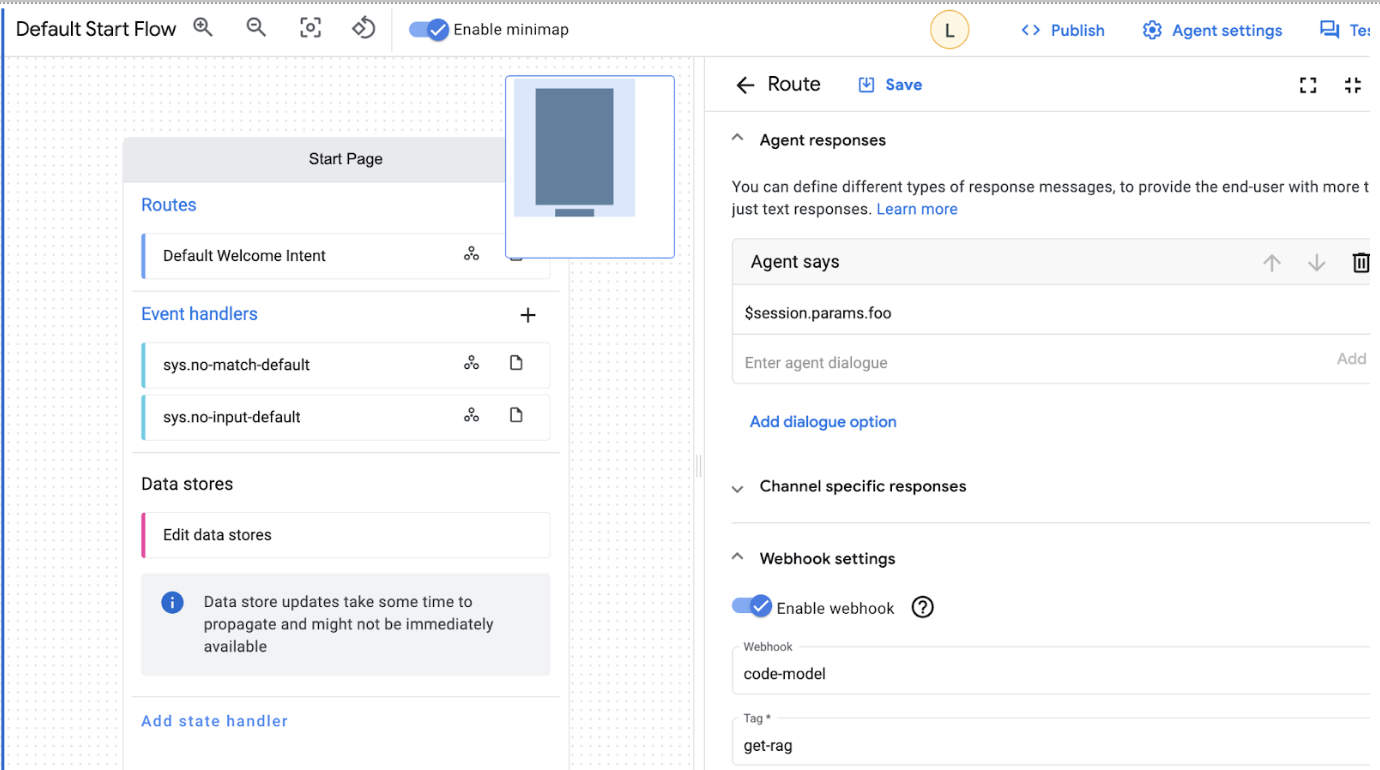

After that, you should be able to search the chatbot in your google chat

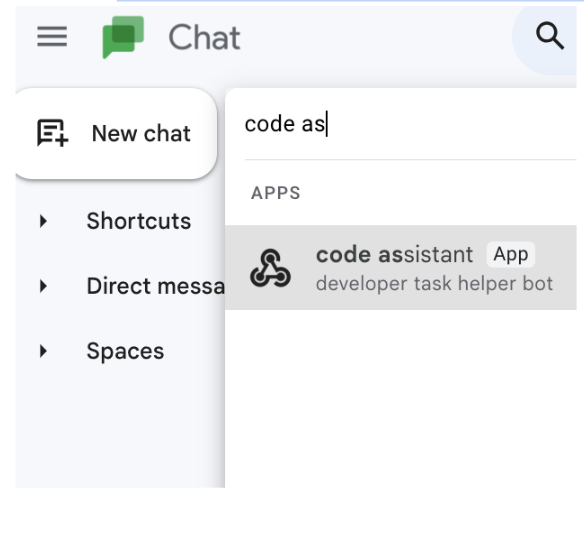